# Project: (K-) Nearest Neighbors


## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient condition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test_death.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_death_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different algorithms for neighbor search and for distance, and justify final selection. Try also different weights to cope with class imbalance and also to balance neighbor proximity. Try to assess somehow confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file and report accuracy, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

Feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN_CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 20%
+ Data preparation - 35%
+ Nearest neighbor method(s) have been used - 15%
+ Probability of death for each test patient is computed - 10%
+ Accuracy of predictions for test patients is calculated (kaggle) - 10%
+ Hyperparameter optimization - 5%
+ Class imbalance management - 5%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%

# Setup

## Import packages and functions

In [61]:
#packages

import pandas as pd
import numpy as np 
import os
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
from datetime import datetime 
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


In [62]:
#functions  

def plot_confusion_matrix(cm, class_labels):
    """Pretty prints a confusion matrix as a figure

    Args:
        cm:  A confusion matrix for example
        [[245, 5 ], 
         [ 34, 245]]
         
        class_labels: The list of class labels to be plotted on x-y axis

    Rerturns:
        Just plots the confusion matrix.
    """
    
    df_cm = pd.DataFrame(cm, index = [i for i in class_labels],
                  columns = [i for i in class_labels])
    sns.set(font_scale=1)
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Predicted label")
    plt.ylabel("Real label")
    plt.show()

def getting_dates(DOBs, ATs):
  admit_dates = []
  birthdays = []
  for i in range(0, len(DOBs)):
      birthdays.append(datetime.strptime(DOBs[i], '%Y-%m-%d %H:%M:%S'))
  for j in range(0, len(ATs)):
      admit_dates.append(datetime.strptime(ATs[j], '%Y-%m-%d %H:%M:%S'))
  return birthdays, admit_dates

def getting_age(birthdays, admit_dates):
  ages = []
  for i in range(0, len(birthdays)):
    ages.append(((admit_dates[i] - birthdays[i]).days)/365.25)
  return ages

def age_fix(data, feature):
    for i in range(0, len(data[feature])):
        if data.loc[i, feature] > 120:
            data.loc[i, feature] = 95
    return data

def drop_feature(features, data):
    for feature in features:
        data = data.drop(feature, axis = 1)
    return data 

def one_hot_encode(features, data):
    for feature in features:
        data = pd.get_dummies(data, prefix=[feature], columns=[feature], drop_first = True)
    return data

def replace(data, feature_to_replace, feature_replacements, new_feature):
    data[feature_to_replace] = data[feature_to_replace].replace(feature_replacements, new_feature)
    return data

In [63]:
#setup and load data

data_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/CML2/Project 1/Data'
kaggle_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/CML2/Project 1/Kaggle submissions'
model_path = '/Users/benseimon/Documents/Barca GSE/Studies/Term 2/CML2/Project 1/Models'
os.chdir(data_path)
comorbidities = pd.read_csv('MIMIC_diagnoses.csv')
diagnosis_definitions = pd.read_csv('MIMIC_metadata_diagnose.csv')
feature_definitions = pd.read_excel('mimic_patient_metadata.xlsx')
train_data = pd.read_csv('mimic_train.csv')
test_data = pd.read_csv('mimic_test_death.csv')

# Step 1: Exploratory Data Analysis

In [64]:
#drop as per instructions - note that offending columns are not in test set so no need to drop 
features_to_drop = ['DOD', 'DISCHTIME', 'DEATHTIME', 'LOS', 'Diff']
train_data = train_data.drop(features_to_drop, axis=1)
test_data = test_data.drop('Diff', axis=1)

In [65]:
train_data.isnull().sum()

HOSPITAL_EXPIRE_FLAG       0
subject_id                 0
hadm_id                    0
icustay_id                 0
HeartRate_Min           2187
HeartRate_Max           2187
HeartRate_Mean          2187
SysBP_Min               2208
SysBP_Max               2208
SysBP_Mean              2208
DiasBP_Min              2209
DiasBP_Max              2209
DiasBP_Mean             2209
MeanBP_Min              2186
MeanBP_Max              2186
MeanBP_Mean             2186
RespRate_Min            2189
RespRate_Max            2189
RespRate_Mean           2189
TempC_Min               2497
TempC_Max               2497
TempC_Mean              2497
SpO2_Min                2203
SpO2_Max                2203
SpO2_Mean               2203
Glucose_Min              253
Glucose_Max              253
Glucose_Mean             253
GENDER                     0
DOB                        0
ADMITTIME                  0
ADMISSION_TYPE             0
INSURANCE                  0
RELIGION                   0
MARITAL_STATUS

In [66]:
test_data.isnull().sum()

subject_id          0
hadm_id             0
icustay_id          0
HeartRate_Min     545
HeartRate_Max     545
HeartRate_Mean    545
SysBP_Min         551
SysBP_Max         551
SysBP_Mean        551
DiasBP_Min        552
DiasBP_Max        552
DiasBP_Mean       552
MeanBP_Min        547
MeanBP_Max        547
MeanBP_Mean       547
RespRate_Min      546
RespRate_Max      546
RespRate_Mean     546
TempC_Min         638
TempC_Max         638
TempC_Mean        638
SpO2_Min          551
SpO2_Max          551
SpO2_Mean         551
Glucose_Min        58
Glucose_Max        58
Glucose_Mean       58
GENDER              0
DOB                 0
ADMITTIME           0
ADMISSION_TYPE      0
INSURANCE           0
RELIGION            0
MARITAL_STATUS    180
ETHNICITY           0
DIAGNOSIS           0
ICD9_diagnosis      0
FIRST_CAREUNIT      0
dtype: int64

## 1a: Numerical features

### 1ai: Generate age variable

Using 'DOB' and 'ADMITTIME' we create an age variable. Note that using 'Diff is not necessary since you would simply apply diff to both columns. 

According to this source (https://github.com/MIT-LCP/mimic-code/issues/637) the data anonymisation process assigns anyone older than 89 to an age close to 300. As a result, I replace any realistic ages to age of 95 (arbitrary). 

Note that purpose of creating the variable is driven by a simple hypothesis that old age increases the likelihood of dying. 

In [67]:
#create age variable for training set
DoB_train, admit_date_train = getting_dates(train_data['DOB'], train_data['ADMITTIME'])
ages = getting_age(DoB_train, admit_date_train)
train_data['AGE'] = ages
print("Distribution before amending those with an unrealistic age")
print(train_data['AGE'].describe())
train_data = age_fix(train_data, 'AGE')
train_data = drop_feature(['DOB', 'ADMITTIME'], train_data)
print("Distribution after amending those with an unrealistic age")
print(train_data['AGE'].describe())

Distribution before amending those with an unrealistic age
count    20885.000000
mean        75.360202
std         55.672686
min         15.049966
25%         53.305955
50%         65.661875
75%         78.017796
max        310.165640
Name: AGE, dtype: float64
Distribution after amending those with an unrealistic age
count    20885.000000
mean        64.454867
std         17.554025
min         15.049966
25%         53.305955
50%         65.661875
75%         78.017796
max         95.000000
Name: AGE, dtype: float64


In [68]:
#create age variable for test set
DOB_test, admit_date_test = getting_dates(test_data['DOB'], test_data['ADMITTIME'])
ages = getting_age(DOB_test, admit_date_test)
test_data['AGE'] = ages
print("Distribution before amending those with an unrealistic age")
print(test_data['AGE'].describe())
test_data = age_fix(test_data, 'AGE')
test_data = drop_feature(['DOB', 'ADMITTIME'], test_data)
print("Distribution after amending those with an unrealistic age")
print(test_data['AGE'].describe())

Distribution before amending those with an unrealistic age
count    5221.000000
mean       75.561054
std        54.890575
min        15.195072
25%        53.771389
50%        66.236824
75%        78.258727
max       310.272416
Name: AGE, dtype: float64
Distribution after amending those with an unrealistic age
count    5221.000000
mean       64.925820
std        17.278221
min        15.195072
25%        53.771389
50%        66.236824
75%        78.258727
max        95.000000
Name: AGE, dtype: float64


### 1aii: Investigate relationship between outcome and numerical variables

In [69]:
#assign features
identifiers = ['subject_id', 'hadm_id', 'icustay_id']
numerical_features = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'AGE']
categorical_features = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT']
diagnosis_features = ['DIAGNOSIS','ICD9_diagnosis']
target = ['HOSPITAL_EXPIRE_FLAG']

In [70]:
#check
len(identifiers+numerical_features+categorical_features+diagnosis_features+target) == train_data.shape[1]

True

<AxesSubplot:>

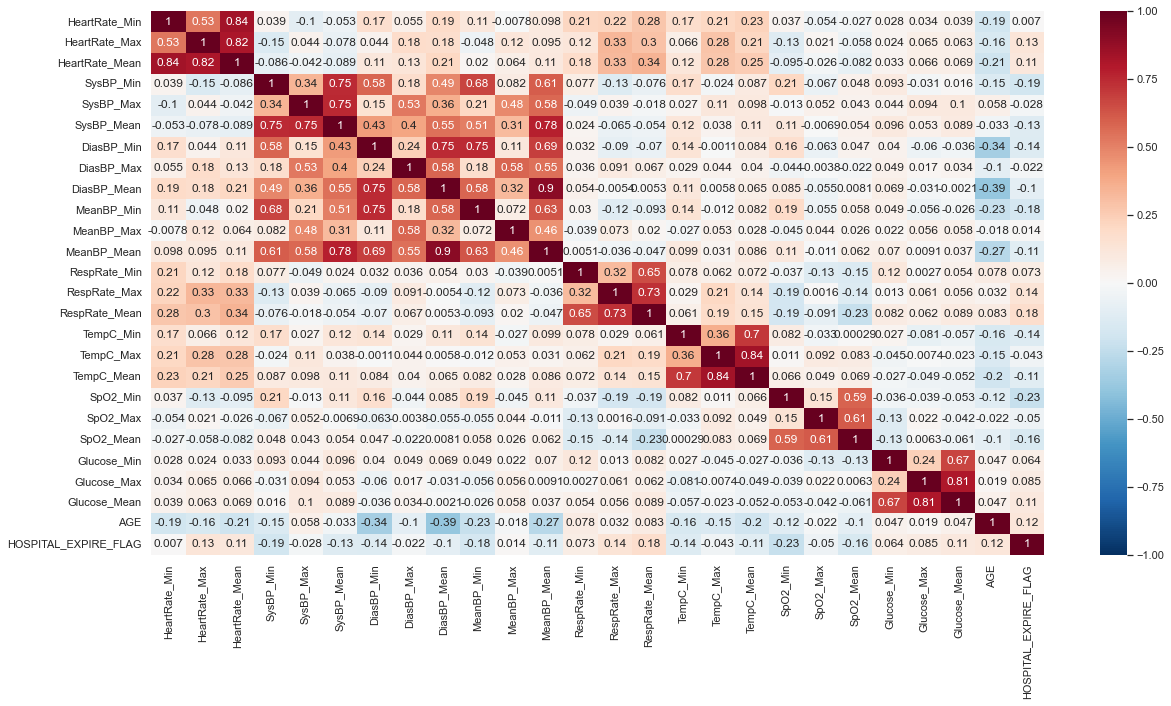

In [71]:
corr_numerical = train_data[numerical_features+target].corr()
sns.set(rc = {'figure.figsize':(20,10)})
sns.heatmap(corr_numerical, cmap = 'RdBu_r', linecolor = 'white', vmin=-1, vmax=1, annot = True)

In [72]:
corr_numerical['HOSPITAL_EXPIRE_FLAG'].sort_values(ascending = False)

HOSPITAL_EXPIRE_FLAG    1.000000
RespRate_Mean           0.175122
RespRate_Max            0.135877
HeartRate_Max           0.129469
AGE                     0.123034
HeartRate_Mean          0.110773
Glucose_Mean            0.105205
Glucose_Max             0.084702
RespRate_Min            0.072560
Glucose_Min             0.064290
MeanBP_Max              0.014403
HeartRate_Min           0.006973
DiasBP_Max             -0.022246
SysBP_Max              -0.028490
TempC_Max              -0.042721
SpO2_Max               -0.049621
DiasBP_Mean            -0.099773
TempC_Mean             -0.110223
MeanBP_Mean            -0.113767
SysBP_Mean             -0.128680
TempC_Min              -0.136591
DiasBP_Min             -0.138257
SpO2_Mean              -0.156872
MeanBP_Min             -0.176074
SysBP_Min              -0.194698
SpO2_Min               -0.234060
Name: HOSPITAL_EXPIRE_FLAG, dtype: float64

Clear positive correlation for RespRate_Mean, RespRate_Max, HeartRate_Max, HeartRate_Mean, Glucose_Mean and our new variable AGE

Clear negative correlation for DiasBP_Mean, TempC_Mean, MeanBP_Mean, SysBP_Mean, TempC_Min, DiasBP_Min,           SpO2_Mean, MeanBP_Min, SysBP_Min, SpO2_Min

## Categorical features

In [73]:
train_data[categorical_features].nunique()

GENDER             2
ADMISSION_TYPE     3
INSURANCE          5
RELIGION          17
MARITAL_STATUS     7
ETHNICITY         41
FIRST_CAREUNIT     5
dtype: int64

Ethnicity and religion have a higher number of unique categories. Let's address this to reduce dimensionality. 

### Ethnicities

In [74]:
train_data['ETHNICITY'].value_counts()

WHITE                                                       15112
BLACK/AFRICAN AMERICAN                                       1977
UNABLE TO OBTAIN                                              577
UNKNOWN/NOT SPECIFIED                                         568
HISPANIC OR LATINO                                            562
OTHER                                                         489
ASIAN                                                         265
PATIENT DECLINED TO ANSWER                                    175
HISPANIC/LATINO - PUERTO RICAN                                155
ASIAN - CHINESE                                               146
BLACK/CAPE VERDEAN                                            126
WHITE - RUSSIAN                                               117
BLACK/HAITIAN                                                  72
HISPANIC/LATINO - DOMINICAN                                    59
ASIAN - ASIAN INDIAN                                           58
WHITE - OT

In [75]:
#categorise ethnicities 
NATIVE = ['AMERICAN INDIAN/ALASKA NATIVE',
 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',  'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']
ASIAN = ['ASIAN',
 'ASIAN - ASIAN INDIAN',
 'ASIAN - CAMBODIAN',
 'ASIAN - CHINESE',
 'ASIAN - FILIPINO',
 'ASIAN - JAPANESE',
 'ASIAN - KOREAN',
 'ASIAN - OTHER',
 'ASIAN - THAI',
 'ASIAN - VIETNAMESE']
BLACK = ['BLACK/AFRICAN',
 'BLACK/AFRICAN AMERICAN',
 'BLACK/CAPE VERDEAN',
 'BLACK/HAITIAN']
OTHER = ['CARIBBEAN ISLAND', 'OTHER', 'MIDDLE EASTERN','MULTI RACE ETHNICITY']

HISPANIC_LATINO = ['HISPANIC OR LATINO',
 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
 'HISPANIC/LATINO - COLOMBIAN',
 'HISPANIC/LATINO - CUBAN',
 'HISPANIC/LATINO - DOMINICAN',
 'HISPANIC/LATINO - GUATEMALAN',
 'HISPANIC/LATINO - HONDURAN',
 'HISPANIC/LATINO - MEXICAN',
 'HISPANIC/LATINO - PUERTO RICAN',
 'HISPANIC/LATINO - SALVADORAN', 
                   'SOUTH AMERICAN']
UNKNOWN = ['UNABLE TO OBTAIN',
 'UNKNOWN/NOT SPECIFIED']
WHITE = ['WHITE',
 'WHITE - BRAZILIAN',
 'WHITE - EASTERN EUROPEAN',
 'WHITE - OTHER EUROPEAN',
 'WHITE - RUSSIAN',
        'PORTUGUESE']
replacing_ethnicities = [NATIVE, ASIAN, BLACK, OTHER, HISPANIC_LATINO, UNKNOWN, WHITE]
replacing_ethnicities_str = ['NATIVE', 'ASIAN', 'BLACK', 'OTHER', 'HISPANIC_LATINO', 'UNKNOWN', 'WHITE']

#'PATIENT DECLINED TO ANSWER' are left as is

In [76]:
#apply categorisation of ethnicities to dataframe
counter = 0
for i in replacing_ethnicities:
    train_data = replace(train_data, 'ETHNICITY', i, replacing_ethnicities_str[counter])
    test_data = replace(test_data, 'ETHNICITY', i, replacing_ethnicities_str[counter])
    counter += 1

In [77]:
train_data['ETHNICITY'].value_counts()

WHITE                         15370
BLACK                          2201
UNKNOWN                        1145
HISPANIC_LATINO                 859
OTHER                           569
ASIAN                           545
PATIENT DECLINED TO ANSWER      175
NATIVE                           21
Name: ETHNICITY, dtype: int64

### Religion


In [18]:
train_data['RELIGION'].value_counts()

CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: RELIGION, dtype: int64

In [19]:
#crude categorisation of religions to reduce dimensionality 
religion_other = ['HEBREW', 'UNITARIAN-UNIVERSALIST', 'HINDU', 'GREEK ORTHODOX',"JEHOVAH'S WITNESS", "BUDDHIST", 'MUSLIM', 'OTHER', 'CHRISTIAN SCIENTIST', 'EPISCOPALIAN', 'ROMANIAN EAST. ORTH', '7TH DAY ADVENTIST'] 
train_data = replace(train_data, 'RELIGION', religion_other, 'OTHER')
test_data = replace(test_data, 'RELIGION', religion_other, 'OTHER')

In [20]:
train_data['RELIGION'].value_counts()

CATHOLIC             7655
NOT SPECIFIED        5398
PROTESTANT QUAKER    2753
JEWISH               1840
OTHER                1724
UNOBTAINABLE         1515
Name: RELIGION, dtype: int64

### Investigate relationship between outcome and categorical variables

In [21]:
list_of_dfs = []
categorical_check = pd.DataFrame(columns = ['HOSPITAL_EXPIRE_FLAG', 'Sub-category', 'Counts', 'Sum', '%', 'Variable'])
for i in categorical_features:
    new_col_count = str(i+'_count')
    new_col_sum = str(i+'sum')
    counts = train_data.groupby('HOSPITAL_EXPIRE_FLAG').agg({i: 'value_counts'}).rename(columns = {i: new_col_count}).reset_index()
    totals = counts.groupby(i).agg({new_col_count: sum}).rename(columns = {new_col_count: new_col_sum}).reset_index()
    counts = pd.merge(counts, totals, how ='left', on=i)
    counts['%'] = counts[new_col_count]/counts[new_col_sum]
    counts['Variable'] = i
    counts.columns = categorical_check.columns
    categorical_check = pd.concat([categorical_check, counts], ignore_index=True)

In [22]:
for i in categorical_features:
    print(categorical_check[(categorical_check['HOSPITAL_EXPIRE_FLAG'] == 1) & (categorical_check['Variable'] == i)].sort_values(by='%', ascending = False))

  HOSPITAL_EXPIRE_FLAG Sub-category Counts    Sum         % Variable
3                    1            F   1057   9126  0.115823   GENDER
2                    1            M   1288  11759  0.109533   GENDER
  HOSPITAL_EXPIRE_FLAG Sub-category Counts    Sum         %        Variable
7                    1    EMERGENCY   2237  17817  0.125554  ADMISSION_TYPE
9                    1       URGENT     15    220  0.068182  ADMISSION_TYPE
8                    1     ELECTIVE     93   2848  0.032654  ADMISSION_TYPE
   HOSPITAL_EXPIRE_FLAG Sub-category Counts    Sum         %   Variable
19                    1     Self Pay     28    194  0.144330  INSURANCE
15                    1     Medicare   1576  11718  0.134494  INSURANCE
16                    1      Private    537   6245  0.085989  INSURANCE
17                    1     Medicaid    168   2117  0.079358  INSURANCE
18                    1   Government     36    611  0.058920  INSURANCE
   HOSPITAL_EXPIRE_FLAG       Sub-category Counts   Sum  

Summary:

- Limited/no variation by type: Gender
- Admission_type: Emergency = higher likelihood of death
- Insurance: Self-pay/medicare = higher likelihood of death
- Religion, marital_status, ethnicity: unknown categorisation = higher likelihood of death
- First care unit: CSRU = lower likelihood of death

In [23]:
train_data[categorical_features].nunique()

GENDER            2
ADMISSION_TYPE    3
INSURANCE         5
RELIGION          6
MARITAL_STATUS    7
ETHNICITY         8
FIRST_CAREUNIT    5
dtype: int64

Have managed to reduce dimensionality so will one_hot_encode for all features here

In [24]:
categorical_check[(categorical_check['HOSPITAL_EXPIRE_FLAG'] == 1)].sort_values(by='%', ascending=False).head(30)

,HOSPITAL_EXPIRE_FLAG,Sub-category,Counts,Sum,%,Variable
44,1,UNKNOWN (DEFAULT),26,103,0.252427,MARITAL_STATUS
54,1,UNKNOWN,237,1145,0.206987,ETHNICITY
29,1,UNOBTAINABLE,288,1515,0.190099,RELIGION
19,1,Self Pay,28,194,0.144330,INSURANCE
60,1,NATIVE,3,21,0.142857,ETHNICITY
66,1,MICU,1205,8640,0.139468,FIRST_CAREUNIT
41,1,WIDOWED,388,2819,0.137637,MARITAL_STATUS
15,1,Medicare,1576,11718,0.134494,INSURANCE
56,1,ASIAN,71,545,0.130275,ETHNICITY
30,1,JEWISH,234,1840,0.127174,RELIGION


To note that we may have some structurally missing data since unknown ethnicity/religion/marital status have high proportions of death

# Step 2: Dealing with missing values

In [25]:
#report nas
train_data.isnull().sum()

HOSPITAL_EXPIRE_FLAG       0
subject_id                 0
hadm_id                    0
icustay_id                 0
HeartRate_Min           2187
HeartRate_Max           2187
HeartRate_Mean          2187
SysBP_Min               2208
SysBP_Max               2208
SysBP_Mean              2208
DiasBP_Min              2209
DiasBP_Max              2209
DiasBP_Mean             2209
MeanBP_Min              2186
MeanBP_Max              2186
MeanBP_Mean             2186
RespRate_Min            2189
RespRate_Max            2189
RespRate_Mean           2189
TempC_Min               2497
TempC_Max               2497
TempC_Mean              2497
SpO2_Min                2203
SpO2_Max                2203
SpO2_Mean               2203
Glucose_Min              253
Glucose_Max              253
Glucose_Mean             253
GENDER                     0
ADMISSION_TYPE             0
INSURANCE                  0
RELIGION                   0
MARITAL_STATUS           722
ETHNICITY                  0
DIAGNOSIS     

In [26]:
#report nas
test_data.isnull().sum()

subject_id          0
hadm_id             0
icustay_id          0
HeartRate_Min     545
HeartRate_Max     545
HeartRate_Mean    545
SysBP_Min         551
SysBP_Max         551
SysBP_Mean        551
DiasBP_Min        552
DiasBP_Max        552
DiasBP_Mean       552
MeanBP_Min        547
MeanBP_Max        547
MeanBP_Mean       547
RespRate_Min      546
RespRate_Max      546
RespRate_Mean     546
TempC_Min         638
TempC_Max         638
TempC_Mean        638
SpO2_Min          551
SpO2_Max          551
SpO2_Mean         551
Glucose_Min        58
Glucose_Max        58
Glucose_Mean       58
GENDER              0
ADMISSION_TYPE      0
INSURANCE           0
RELIGION            0
MARITAL_STATUS    180
ETHNICITY           0
DIAGNOSIS           0
ICD9_diagnosis      0
FIRST_CAREUNIT      0
AGE                 0
dtype: int64

## Numerical features

In [28]:
train_data[numerical_features].isnull().sum()

HeartRate_Min     2187
HeartRate_Max     2187
HeartRate_Mean    2187
SysBP_Min         2208
SysBP_Max         2208
SysBP_Mean        2208
DiasBP_Min        2209
DiasBP_Max        2209
DiasBP_Mean       2209
MeanBP_Min        2186
MeanBP_Max        2186
MeanBP_Mean       2186
RespRate_Min      2189
RespRate_Max      2189
RespRate_Mean     2189
TempC_Min         2497
TempC_Max         2497
TempC_Mean        2497
SpO2_Min          2203
SpO2_Max          2203
SpO2_Mean         2203
Glucose_Min        253
Glucose_Max        253
Glucose_Mean       253
AGE                  0
dtype: int64

Given the high correlations between groups of variables, the first impression is that imputation could be helpful. For example, imagine we had heart rate min and max, but not mean. A simple regression may help us accurately impute the mean. The same applies across all variables, and then in combination with the iterative imputer we could hopefully produce some reasonable imputations. 

In [29]:
#group
heart_features = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean']
bp_features = ['SysBP_Min','SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean','MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean']
resp_features = ['RespRate_Min','RespRate_Max', 'RespRate_Mean']
temp_features = ['TempC_Min', 'TempC_Max', 'TempC_Mean']
oxygen_features = ['SpO2_Min', 'SpO2_Max', 'SpO2_Mean']
glucose_features = ['Glucose_Min', 'Glucose_Max','Glucose_Mean']

In [30]:
train_data[heart_features+bp_features+resp_features+temp_features+oxygen_features+glucose_features].isnull().sum(axis=1).value_counts()

0     18113
21     2183
3       545
6        36
9         3
18        2
12        2
15        1
dtype: int64

However, here we see that for those observations with missing values, a high proportion are actually missing data across all numerical features. The exception seems to be the glucose variables since there are far fewer missing values. 

This has implications for our imputation strategy. This provides a motivation to use the iterative imputer, using the glucose features as the starting point. 

## Marital status

In [31]:
marital_unknown = train_data['MARITAL_STATUS'] == 'UNKNOWN (DEFAULT)'
ethnicity_unknown = train_data['ETHNICITY'] == 'UNKNOWN'
religion_unknown = train_data['RELIGION'] == 'UNOBTAINABLE'
religion_unspecified = train_data['RELIGION'] == 'NOT SPECIFIED'
marital_na = train_data['MARITAL_STATUS'].isna()

print(len(train_data[marital_na]))
print(len(train_data[marital_na&(religion_unknown|ethnicity_unknown)]))

722
527


In [32]:
train_data[marital_na]['HOSPITAL_EXPIRE_FLAG'].sum()/len(train_data[marital_na])

0.2548476454293629

In [33]:
train_data['MARITAL_STATUS'].value_counts()

MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
SEPARATED             240
UNKNOWN (DEFAULT)     103
LIFE PARTNER           14
Name: MARITAL_STATUS, dtype: int64

Implications for imputation method. A simple method would be to impute the modal category but this doesn't seem sensible here given that a) high proportion of deaths for those with na and b) we notice those with an NA for marital status also tend to have classified relgion/ethnicity as unknown. 

As a result I classify these individuals into their own category - "Missing". 

In [34]:
train_data['MARITAL_STATUS'].fillna('MISSING', inplace = True)
test_data['MARITAL_STATUS'].fillna('MISSING', inplace = True)
train_data['MARITAL_STATUS'].value_counts()

MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
MISSING               722
SEPARATED             240
UNKNOWN (DEFAULT)     103
LIFE PARTNER           14
Name: MARITAL_STATUS, dtype: int64

# Step 3: Generate new features

## 3a: Comorbidities

In [35]:
comorbidities.isnull().sum()

SUBJECT_ID     0
HADM_ID        0
SEQ_NUM       47
ICD9_CODE     47
dtype: int64

In the the comorbidities data we have some nas for SEQ_NUM (refers to number of additional comorbidities diagnosed for a given HADM_ID), and ICD9_CODE. Let's investigate a bit further. 

In [36]:
print(comorbidities[comorbidities['SEQ_NUM'].isnull() == True])
print(comorbidities[comorbidities['SEQ_NUM'].isnull() == True].shape)
comorbidities.shape

        SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
36503         9998   108282      NaN       NaN
74075        28700   104588      NaN       NaN
79039        27934   152077      NaN       NaN
106220        3369   126808      NaN       NaN
107563       23081   105970      NaN       NaN
115158       17964   196087      NaN       NaN
139896       24886   166997      NaN       NaN
161360       12607   190435      NaN       NaN
168855       13890   113170      NaN       NaN
169511       26690   196643      NaN       NaN
189903        9035   188023      NaN       NaN
216604       16213   199739      NaN       NaN
219007       18006   140889      NaN       NaN
281482       23407   119146      NaN       NaN
288388        8818   111608      NaN       NaN
296439       17269   176570      NaN       NaN
302635        7544   116945      NaN       NaN
309494       31866   182252      NaN       NaN
314075       24188   163059      NaN       NaN
333731       17796   142890      NaN       NaN
352366       

(651047, 4)

So we have 47 rows with nas out of 651,047 which is very few. In any case, let's take the first subject_id as an example. 

In [37]:
comorbidities[comorbidities['SUBJECT_ID'] == 9998]

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
36503,9998,108282,NaN,NaN
36504,9998,144947,1.0,80025
36505,9998,144947,2.0,5185
36506,9998,144947,3.0,3485
36507,9998,144947,4.0,3484
36508,9998,144947,5.0,E8181


In other words, the nas represent individuals who have gone to hospital but have not received a diagnosis. However, this doesn't raise an issue since we will only be considering the no of comorbidities for each hospital admission. We see this later when applying the group by.

In [38]:
#Use group by to get the no. of comorbitidies per hospital admission
comorbidities_count = comorbidities.groupby(['SUBJECT_ID','HADM_ID'], as_index = False).agg({'ICD9_CODE': 'nunique'})
#rename columns for readability 
comorbidities_count.rename(columns={'ICD9_CODE': 'No_comorbs'}, inplace=True)

Below shows that we capture the correct number of diagnoses per hospital admission.

In [39]:
#confirm no need to remove nas
comorbidities_count[comorbidities_count['SUBJECT_ID']==9998]

,SUBJECT_ID,HADM_ID,No_comorbs
12247,9998,108282,0
12248,9998,144947,5


In [ ]:
#merge with dataset
comorbidities_count.columns= comorbidities_count.columns.str.lower()
train_data = train_data.merge(comorbidities_count[['subject_id', 'hadm_id', 'no_comorbs']], on=['subject_id', 'hadm_id'])
test_data = test_data.merge(comorbidities_count[['subject_id', 'hadm_id', 'no_comorbs']], on=['subject_id', 'hadm_id'])

## 3b: Diagnosis

In [40]:
total_survived = train_data['HOSPITAL_EXPIRE_FLAG'].value_counts()[0]
total_died = train_data['HOSPITAL_EXPIRE_FLAG'].value_counts()[1]

In [41]:
total_diagnosed = train_data['ICD9_diagnosis'].value_counts().reset_index().rename(columns = {'ICD9_diagnosis': 'no_diagnosed', 'index': 'ICD9_diagnosis'})

In [42]:
by_diagnosis = train_data.groupby('ICD9_diagnosis').agg({'HOSPITAL_EXPIRE_FLAG': 'sum'}).sort_values(by = 'HOSPITAL_EXPIRE_FLAG', ascending = False).rename(columns = {'HOSPITAL_EXPIRE_FLAG': 'died'}).reset_index()
by_diagnosis = pd.merge(by_diagnosis, total_diagnosed, how = 'left', on ='ICD9_diagnosis')
by_diagnosis['survived'] = by_diagnosis['no_diagnosed'] -  by_diagnosis['died']
by_diagnosis['%_of_total_dead'] = by_diagnosis['died']/total_died
by_diagnosis['%_of_diagnosed_dead'] = by_diagnosis['died']/by_diagnosis['no_diagnosed']

In [46]:
len(train_data[train_data['ICD9_diagnosis'] == '0389'])

986

In [50]:
by_diagnosis.sort_values(by = '%_of_total_dead', ascending = False).head(30)

,ICD9_diagnosis,died,no_diagnosed,survived,%_of_total_dead,%_of_diagnosed_dead
0,0389,301,986,685,0.128358,0.305274
1,431,135,444,309,0.057569,0.304054
2,51881,90,399,309,0.038380,0.225564
3,430,47,228,181,0.020043,0.206140
4,486,45,319,274,0.019190,0.141066
5,5070,38,270,232,0.016205,0.140741
6,43411,36,172,136,0.015352,0.209302
7,41071,34,549,515,0.014499,0.061931
8,43491,27,112,85,0.011514,0.241071
9,20500,26,55,29,0.011087,0.472727


In [58]:
by_diagnosis[by_diagnosis['died']>0].sort_values(by = '%_of_diagnosed_dead', ascending = False)

,ICD9_diagnosis,died,no_diagnosed,survived,%_of_total_dead,%_of_diagnosed_dead
331,5078,1,1,0,0.000426,1.000000
394,1598,1,1,0,0.000426,1.000000
154,80025,3,3,0,0.001279,1.000000
410,1943,1,1,0,0.000426,1.000000
355,05479,1,1,0,0.000426,1.000000
...,...,...,...,...,...,...
56,4241,9,534,525,0.003838,0.016854
348,51919,1,92,91,0.000426,0.010870
48,41401,10,1098,1088,0.004264,0.009107
367,56212,1,127,126,0.000426,0.007874


In [48]:
deadly_diagnosis = list(by_diagnosis[by_diagnosis['%_of_total_dead']>0]['ICD9_diagnosis'].unique())

In [ ]:
len(deadly_diagnosis)

In [ ]:
train_data[train_data['ICD9_diagnosis'].isin(deadly_diagnosis)]

In [ ]:
len(by_diagnosis)

## KNN

In [40]:
numerical_features
numerical_transformer = Pipeline(
    steps=[("imputer", IterativeImputer(random_state=0, missing_values = np.nan, initial_strategy = 'mean', max_iter=30,imputation_order = 'ascending', add_indicator=True)), ("scaler", StandardScaler())]
)

#(SimpleImputer(missing_values = np.nan, strategy = 'mean', add_indicator=True)
categorical_features
categorical_transformer = OneHotEncoder(drop='if_binary',handle_unknown="ignore")
#set handle_unknown to ignore, since if it encounters an unseen categorical type in the test set, it will automatically create a column of 0s 

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

knn_estimator = KNeighborsClassifier(algorithm='auto', weights='distance') 

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
knn_pipeline = imbPipeline([("preprocessor", preprocessor), ('sampling', SMOTE()), ("classifier", knn_estimator)]
)

grid_values = [{'classifier__n_neighbors':[1,5,10,50,100,200,500],
               #'classifier__weights':['uniform', 'distance'], 
                'classifier__p':[1, 2]}] #distance consistently outperforms uniform so commented out
grid_knn = HalvingGridSearchCV(knn_pipeline, param_grid = grid_values, scoring = 'roc_auc', cv = 5, verbose = 3) #used to narrow down range for full GridSearch. First run used 


In [ ]:
grid_knn.fit(train_data[numerical_features+categorical_features], train_data[target])

/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 2320
max_resources_: 20885
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 14
n_resources: 2320
Fitting 5 folds for each of 14 candidates, totalling 70 fits


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=1, classifier__p=1;, score=(train=1.000, test=0.611) total time=   4.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=1, classifier__p=1;, score=(train=1.000, test=0.566) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=1, classifier__p=1;, score=(train=1.000, test=0.547) total time=   3.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=1, classifier__p=1;, score=(train=1.000, test=0.580) total time=   5.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=1, classifier__p=1;, score=(train=1.000, test=0.596) total time=   3.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=1, classifier__p=2;, score=(train=1.000, test=0.595) total time=   4.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=1, classifier__p=2;, score=(train=1.000, test=0.593) total time=   4.7s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=1, classifier__p=2;, score=(train=1.000, test=0.581) total time=   3.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=1, classifier__p=2;, score=(train=1.000, test=0.583) total time=   4.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=1, classifier__p=2;, score=(train=1.000, test=0.638) total time=   3.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=5, classifier__p=1;, score=(train=1.000, test=0.656) total time=   4.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=5, classifier__p=1;, score=(train=1.000, test=0.600) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=5, classifier__p=1;, score=(train=1.000, test=0.648) total time=   3.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=5, classifier__p=1;, score=(train=1.000, test=0.668) total time=   5.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=5, classifier__p=1;, score=(train=1.000, test=0.728) total time=   4.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=5, classifier__p=2;, score=(train=1.000, test=0.662) total time=   4.1s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=5, classifier__p=2;, score=(train=1.000, test=0.612) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=5, classifier__p=2;, score=(train=1.000, test=0.657) total time=   3.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=5, classifier__p=2;, score=(train=1.000, test=0.660) total time=   4.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=5, classifier__p=2;, score=(train=1.000, test=0.709) total time=   4.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=10, classifier__p=1;, score=(train=1.000, test=0.682) total time=   4.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=10, classifier__p=1;, score=(train=1.000, test=0.625) total time=   5.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=10, classifier__p=1;, score=(train=1.000, test=0.688) total time=   3.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=10, classifier__p=1;, score=(train=1.000, test=0.704) total time=   5.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=10, classifier__p=1;, score=(train=1.000, test=0.720) total time=   4.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=10, classifier__p=2;, score=(train=1.000, test=0.682) total time=   4.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=10, classifier__p=2;, score=(train=1.000, test=0.632) total time=   4.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=10, classifier__p=2;, score=(train=1.000, test=0.662) total time=   3.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=10, classifier__p=2;, score=(train=1.000, test=0.690) total time=   4.8s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=10, classifier__p=2;, score=(train=1.000, test=0.726) total time=   4.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=50, classifier__p=1;, score=(train=1.000, test=0.727) total time=   4.4s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=50, classifier__p=1;, score=(train=1.000, test=0.682) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=50, classifier__p=1;, score=(train=1.000, test=0.710) total time=   3.4s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=50, classifier__p=1;, score=(train=1.000, test=0.756) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=50, classifier__p=1;, score=(train=1.000, test=0.745) total time=   3.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=50, classifier__p=2;, score=(train=1.000, test=0.732) total time=   4.4s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=50, classifier__p=2;, score=(train=1.000, test=0.693) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=50, classifier__p=2;, score=(train=1.000, test=0.706) total time=   3.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=50, classifier__p=2;, score=(train=1.000, test=0.746) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=50, classifier__p=2;, score=(train=1.000, test=0.774) total time=   4.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=100, classifier__p=1;, score=(train=1.000, test=0.739) total time=   4.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=100, classifier__p=1;, score=(train=1.000, test=0.724) total time=   4.8s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=100, classifier__p=1;, score=(train=1.000, test=0.704) total time=   3.4s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=100, classifier__p=1;, score=(train=1.000, test=0.771) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=100, classifier__p=1;, score=(train=1.000, test=0.753) total time=   3.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=100, classifier__p=2;, score=(train=1.000, test=0.755) total time=   4.4s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=100, classifier__p=2;, score=(train=1.000, test=0.731) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=100, classifier__p=2;, score=(train=1.000, test=0.708) total time=   3.4s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=100, classifier__p=2;, score=(train=1.000, test=0.756) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=100, classifier__p=2;, score=(train=1.000, test=0.777) total time=   4.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=200, classifier__p=1;, score=(train=1.000, test=0.802) total time=   4.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=200, classifier__p=1;, score=(train=1.000, test=0.744) total time=   5.1s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=200, classifier__p=1;, score=(train=1.000, test=0.714) total time=   3.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=200, classifier__p=1;, score=(train=1.000, test=0.778) total time=   5.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=200, classifier__p=1;, score=(train=1.000, test=0.756) total time=   4.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=200, classifier__p=2;, score=(train=1.000, test=0.809) total time=   4.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=200, classifier__p=2;, score=(train=1.000, test=0.756) total time=   4.8s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=200, classifier__p=2;, score=(train=1.000, test=0.712) total time=   3.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=200, classifier__p=2;, score=(train=1.000, test=0.787) total time=   5.1s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=200, classifier__p=2;, score=(train=1.000, test=0.770) total time=   3.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=500, classifier__p=1;, score=(train=1.000, test=0.825) total time=   4.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=500, classifier__p=1;, score=(train=1.000, test=0.762) total time=   4.8s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=500, classifier__p=1;, score=(train=1.000, test=0.744) total time=   3.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=500, classifier__p=1;, score=(train=1.000, test=0.793) total time=   4.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=500, classifier__p=1;, score=(train=1.000, test=0.756) total time=   3.8s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=500, classifier__p=2;, score=(train=1.000, test=0.828) total time=   4.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV 2/5] END classifier__n_neighbors=500, classifier__p=2;, score=(train=1.000, test=0.752) total time=   4.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=500, classifier__p=2;, score=(train=1.000, test=0.733) total time=   3.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=500, classifier__p=2;, score=(train=1.000, test=0.798) total time=   4.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=500, classifier__p=2;, score=(train=1.000, test=0.761) total time=   4.0s
----------
iter: 1
n_candidates: 5
n_resources: 6960
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=100, classifier__p=2;, score=(train=1.000, test=0.734) total time=  12.5s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END classifier__n_neighbors=100, classifier__p=2;, score=(train=1.000, test=0.746) total time=  10.1s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=100, classifier__p=2;, score=(train=1.000, test=0.768) total time=  10.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=100, classifier__p=2;, score=(train=1.000, test=0.711) total time=  12.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=100, classifier__p=2;, score=(train=1.000, test=0.720) total time=  12.4s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=200, classifier__p=1;, score=(train=1.000, test=0.762) total time=  12.8s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END classifier__n_neighbors=200, classifier__p=1;, score=(train=1.000, test=0.773) total time=  10.8s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=200, classifier__p=1;, score=(train=1.000, test=0.792) total time=  11.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=200, classifier__p=1;, score=(train=1.000, test=0.735) total time=  12.7s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=200, classifier__p=1;, score=(train=1.000, test=0.742) total time=  13.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=200, classifier__p=2;, score=(train=1.000, test=0.746) total time=  12.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END classifier__n_neighbors=200, classifier__p=2;, score=(train=1.000, test=0.748) total time=  10.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=200, classifier__p=2;, score=(train=1.000, test=0.768) total time=  10.9s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=200, classifier__p=2;, score=(train=1.000, test=0.714) total time=  12.1s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 5/5] END classifier__n_neighbors=200, classifier__p=2;, score=(train=1.000, test=0.719) total time=  12.3s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 1/5] END classifier__n_neighbors=500, classifier__p=2;, score=(train=1.000, test=0.747) total time=  12.2s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 2/5] END classifier__n_neighbors=500, classifier__p=2;, score=(train=1.000, test=0.767) total time=  10.1s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 3/5] END classifier__n_neighbors=500, classifier__p=2;, score=(train=1.000, test=0.762) total time=  11.0s


/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/impute/_iterative.py:699: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/Users/benseimon/opt/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


[CV 4/5] END classifier__n_neighbors=500, classifier__p=2;, score=(train=1.000, test=0.729) total time=  12.5s


## SVM

In [1]:
numerical_features
numerical_transformer = Pipeline(
    steps=[("imputer", IterativeImputer(random_state=0, missing_values = np.nan, initial_strategy = 'mean', max_iter=30,imputation_order = 'ascending', add_indicator=True)), ("scaler", StandardScaler())]
)

#(SimpleImputer(missing_values = np.nan, strategy = 'mean', add_indicator=True)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

svm_estimator = SVC(probability = True, class_weight = 'balanced', random_state = 5) #class_weight set to balanced since we have an unbalanced dataset. Could have grid searched for none vs balanced, but did not due to time constraints. 

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
svm_pipeline = Pipeline([("preprocessor", preprocessor), ("classifier", knn_estimator)])

grid_values = [{'classifier_kernel': ['linear', 'rbf'],'classifier__C':[0.01, 0.1, 1, 10, 100],
               'classifier__gamma':[0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.99], 'classifier__p':[1, 2]}]
grid_knn = HalvingGridSearchCV(svm_pipeline, param_grid = grid_values, scoring = 'roc_auc', cv = 5, verbose = 3)


NameError: name 'numerical_features' is not defined

## Graveyard

In [ ]:
#1 Preprocessing 

##a

###i - make dummies for categorical features

for_dummy = categorical_features
for_imputation = numerical_features

#dummy = pd.get_dummies(train_data[categorical_features], drop_first = True)
dummy = make_column_transformer((OneHotEncoder(drop = 'if_binary', handle_unknown = 'ignore'), for_dummy), remainder = 'passthrough') #set handle_unknown to ignore, since if it encounters an unseen categorical type in the test set, it will automatically create a column of 0s 

###ii - iterative imputer for numerical features
imputer = make_column_transformer((IterativeImputer(random_state=0, missing_values = np.nan, initial_strategy = 'mean', max_iter=30,imputation_order = 'ascending', add_indicator=True), for_imputation), (StandardScaler(), for_imputation), remainder = 'passthrough') #ascending i.e. start with columns with fewest missing values 
#imputer = make_column_transformer((SimpleImputer(missing_values = np.nan, strategy = 'mean', add_indicator=True), for_imputation), (StandardScaler(), for_imputation), remainder = 'passthrough') #ascending i.e. start with columns with fewest missing values 

#2 estimator 
knn_estimator = KNeighborsClassifier(algorithm='auto', weights='distance') 
#choose not to grid search over different algorithms since sklearn selects the most appropriate, but am aware there are multiple options. 

#3 pipeline
knn_pipeline = imbPipeline([#('dummy', dummy), 
                    ('imputer', imputer),
                    ('scale', StandardScaler())
                            ('sampling', SMOTE()),
                            ('classifier', knn_estimator)])

grid_values = [{'classifier__n_neighbors':[1]#,10,50,100,200, 500],
               ,'classifier__weights':['uniform', 'distance'], 'classifier__p':[1]}]
grid_knn = GridSearchCV(knn_pipeline, param_grid = grid_values, scoring = 'roc_auc', cv = 5, verbose = 3)
   

In [ ]:
grid_knn.fit(train_data_check.drop(target, axis=1), train_data[target])

In [ ]:

imputer__estimator = BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=20, random_state=0),
    KNeighborsRegressor(n_neighbors=2)


numeric_transformer_iterative = Pipeline(
    steps=[("imputer", (random_state=0, estimator=my_estimator, max_iter=30,add_indicator=True)), ("scaler", StandardScaler())]
)

numeric_transformer_simple = Pipeline(steps=[("imputer", SimpleImputer(strategy="mean", add_indicator = True)), ("scaler", StandardScaler())]
)

categorical_features = 
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

knn_preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),])

#make dummies
train_data = one_hot_encode(['ETHNICITY'], train_data)
test_data = one_hot_encode(['ETHNICITY'], test_data)
                                                train_data = one_hot_encode(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS',
                               'FIRST_CAREUNIT', 'RELIGION'], train_data)
test_data = one_hot_encode(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'MARITAL_STATUS',
                               'FIRST_CAREUNIT', 'RELIGION'], test_data)
print(train_data.shape)
print(test_data.shape)
                                                
                                                
#2 Imputer 

#3 Estimator 


#4 Make pipeline 

pipe_knn = imbPipeline([('dummy', column_dummy), 
                ('imputer', KNNImputer(missing_values=np.nan, n_neighbors = 100, weights = 'distance', add_indicator = False)),
                ('preprocessing', preprocessing.StandardScaler()),
                ('sampling', SMOTE()),
                #('features', fs.RFECV(estimator = DecisionTreeClassifier(class_weight = 'balanced'),
                #                      step = 10, cv = 5, scoring = 'roc_auc', verbose = 0)),
                ('classifier', KNeighborsClassifier(n_neighbors = 20,
                                                    weights = 'distance',
                                                    algorithm = 'auto'))])
knn_pipeline = imbPipeline([("preprocessor", knn_preprocessor), ("classifier", knn_estimator)])

#5 Run GridSearch 

grid_values = [#{'imputer__n_neighbors':[100]},
               {'classifier__n_neighbors':[1,5,10,50,100,200, 500],
               'classifier__weights':['uniform', 'distance'], 'classifier__p':[1, 2]}]
grid_knn = GridSearchCV(knn_pipeline, param_grid = grid_values, scoring = 'roc_auc', cv = 5, verbose = 3)
   

    # load the model from disk and use it


#6 Train, fit and save model 
grid_knn.fit(X_train, y_train)
filename = 'my_model.sav'
pickle.dump(my_model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model.predict_proba(xtest)

In [ ]:
missing_cols = set(train_data.columns) - set(test_data.columns)
missing_cols

In [ ]:
for i in categorical_features:
    print(train_data.groupby(i).agg({'HOSPITAL_EXPIRE_FLAG': 'value_counts'}))

So we have some very highly correlated features. With regard to missing values imputation this should prove useful. Simply imputing using the mean/median is a valid approach. However, it is reasonably crude. Take heart rate as an example - not logical to use the mean/median, especially given the high degree of correlation between variables. 

Note that I assume we are in a 'Missing at Random' world. 

In [ ]:
#for each variable, I select the variables which exhibit obvious correlations and investigate the type of correlation by visual inspection
corr[(corr.iloc[:, :]>0.2) | (corr.iloc[:, :] <-0.2)]
highly_correlated = {}
for i in corr.columns:
    correlated_vars = corr[corr[i]>0.2].index
    highly_correlated[i] = correlated_vars

In [ ]:
highly_correlated

In [ ]:
corr[corr['HeartRate_Min']>0.2].index

In [ ]:
sns.pairplot(train_data[numerical_features+target], hue = 'HOSPITAL_EXPIRE_FLAG', diag_kind = 'kde', palette = 'bright')

In [ ]:
train_data[['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean']].isnull().sum(axis=1).value_counts()

In [ ]:
train_data[['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean']]

In [ ]:
train_data[['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean']].isnull()

In [ ]:
train_data[['SysBP_Min','SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean','MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean']].isnull().sum(axis=1).value_counts()

In [ ]:
train_data[['RespRate_Min',
       'RespRate_Max', 'RespRate_Mean']].isnull().sum(axis=1).value_counts()

In [ ]:
train_data[['TempC_Min', 'TempC_Max', 'TempC_Mean']].isnull().sum(axis=1).value_counts()

In [ ]:
train_data.columns

In [ ]:
train_data[['SpO2_Min', 'SpO2_Max', 'SpO2_Mean']].isnull().sum(axis=1).value_counts()

In [ ]:
train_data[['Glucose_Min', 'Glucose_Max',
       'Glucose_Mean']].isnull().sum(axis=1).value_counts()

In [ ]:
train_data[['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean']].isnull().sum(axis=1).value_counts()

In [ ]:
diagnosis_cumulative = np.cumsum(train_data['ICD9_diagnosis'].value_counts(normalize=True).sort_values(ascending=False))
px.area(
x=range(1, diagnosis_cumulative.shape[0]+1), 
y = diagnosis_cumulative,
labels={"x": "diagnosis", "y": "Proportion of patients"})